# Install Libraries

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# Load the Data

In [192]:
# Load the data from the file
file_path = 'C:/Users/earne/OneDrive/Upwork/btc/BTC_HourlyData_CloseOnly2014ThroughMarch2024.csv'
btc_data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
btc_data.head()

,Ticker,Date,Time,Close
0,BTC,3/8/2024,14:00,69192.81
1,BTC,3/8/2024,13:00,68802.87
2,BTC,3/8/2024,12:00,68625.54
3,BTC,3/8/2024,11:00,68532.90
4,BTC,3/8/2024,10:00,67962.26


# Data Prep

## Add Columns for Previous Close, Hourly log return, and Actual Change

In [193]:
#Create new column "log_hourly_returns"
btc_data['Hourly_Log_Return'] = np.log(btc_data['Close'] / btc_data['Close'].shift(1))
btc_data['Previous Close'] = btc_data['Close'].shift(1)
btc_data['Actual Change'] = btc_data['Close'].pct_change() * 100

In [194]:
btc_data.head()

,Ticker,Date,Time,Close,Hourly_Log_Return,Previous Close,Actual Change
0,BTC,3/8/2024,14:00,69192.81,NaN,NaN,NaN
1,BTC,3/8/2024,13:00,68802.87,-0.005651,69192.81,-0.563556
2,BTC,3/8/2024,12:00,68625.54,-0.002581,68802.87,-0.257736
3,BTC,3/8/2024,11:00,68532.90,-0.001351,68625.54,-0.134993
4,BTC,3/8/2024,10:00,67962.26,-0.008361,68532.90,-0.832651


## New column for hourly direction

In [195]:
# Create a new column 'Next_Hour_Direction'
# Since the data is in descending order, we need to compare with the previous row in the dataset
btc_data['Next_Hour_Direction'] = (btc_data['Close'].shift(-1) < btc_data['Close']).astype(int)

# Display the first few rows of the dataframe with the new column
btc_data.head()

,Ticker,Date,Time,Close,Hourly_Log_Return,Previous Close,Actual Change,Next_Hour_Direction
0,BTC,3/8/2024,14:00,69192.81,NaN,NaN,NaN,1
1,BTC,3/8/2024,13:00,68802.87,-0.005651,69192.81,-0.563556,1
2,BTC,3/8/2024,12:00,68625.54,-0.002581,68802.87,-0.257736,1
3,BTC,3/8/2024,11:00,68532.90,-0.001351,68625.54,-0.134993,1
4,BTC,3/8/2024,10:00,67962.26,-0.008361,68532.90,-0.832651,0


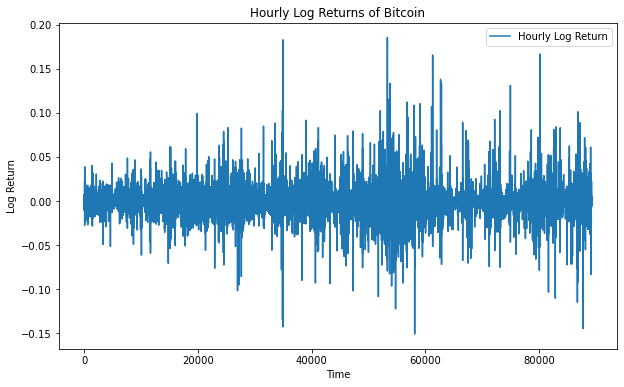

In [196]:
# Plotting the hourly log returns
plt.figure(figsize=(10, 6))
plt.plot(btc_data['Hourly_Log_Return'], label='Hourly Log Return')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.title('Hourly Log Returns of Bitcoin')
plt.legend()
plt.show()

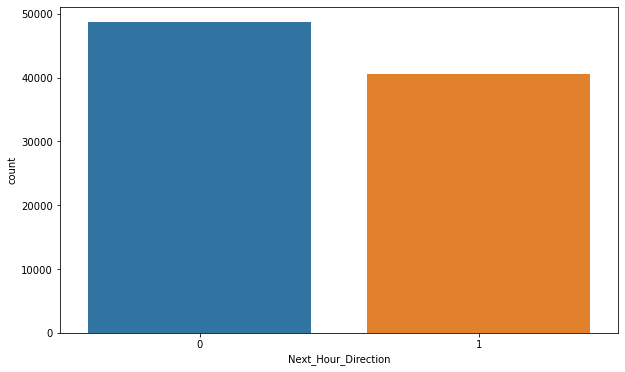

In [197]:
#plot number of up and down hours
plt.figure(figsize= (10,6))
sns.countplot(data=btc_data, x = 'Next_Hour_Direction')
plt.show()

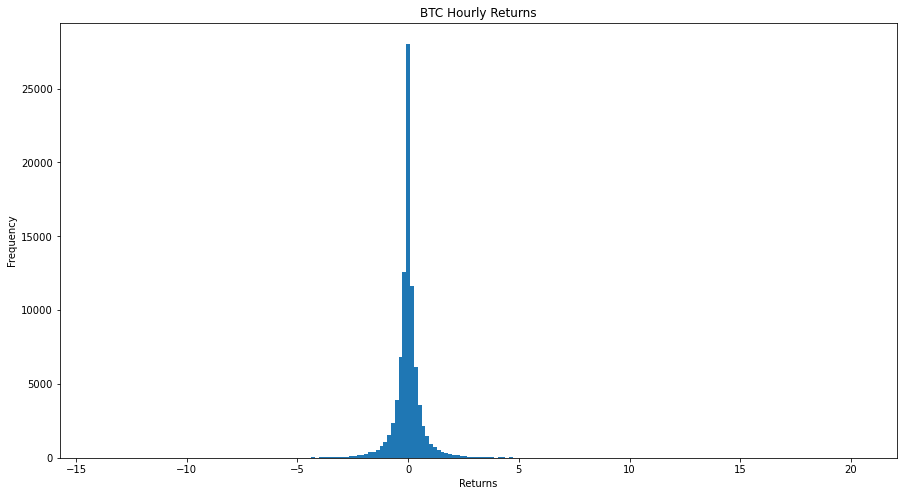

In [198]:
# Plot the histogram of % hourly returns
plt.figure(figsize=(15, 8))
plt.hist(btc_data['Actual Change'],  bins=200)

# Set the title and labels
plt.title(f"BTC Hourly Returns")
plt.xlabel("Returns")
plt.ylabel("Frequency")

# Display the plot
plt.show()

Note about a 60/40 split for overall class balance.

## Splitting the data for the first window to train

In [199]:
btc_data_reversed = btc_data.iloc[::-1].reset_index(drop=True)

number_of_windows = 2

window_size = 720

total_rows = number_of_windows * window_size

trial_data = btc_data_reversed.iloc[:total_rows]

len(trial_data)

1440

In [200]:
trial_data.head()

,Ticker,Date,Time,Close,Hourly_Log_Return,Previous Close,Actual Change,Next_Hour_Direction
0,BTC,1/1/2014,0:00:00,755.91,0.001059,755.11,0.105945,0
1,BTC,1/1/2014,1:00:00,755.11,0.002599,753.15,0.260240,0
2,BTC,1/1/2014,2:00:00,753.15,-0.000664,753.65,-0.066344,0
3,BTC,1/1/2014,3:00:00,753.65,-0.003417,756.23,-0.341166,1
4,BTC,1/1/2014,4:00:00,756.23,-0.001678,757.50,-0.167657,1


In [201]:
# Define hyperparameters
sequence_length = 15
units = 30
activation = 'tanh'
dropout_rate = 0.2
learning_rate = 0.01
epochs = 50
batch_size = 32

In [202]:
#select the first window
first_window_size = 720  # number of hours in the first window
first_window_data =trial_data.iloc[:first_window_size]
first_window_data

,Ticker,Date,Time,Close,Hourly_Log_Return,Previous Close,Actual Change,Next_Hour_Direction
0,BTC,1/1/2014,0:00:00,755.91,0.001059,755.11,0.105945,0
1,BTC,1/1/2014,1:00:00,755.11,0.002599,753.15,0.260240,0
2,BTC,1/1/2014,2:00:00,753.15,-0.000664,753.65,-0.066344,0
3,BTC,1/1/2014,3:00:00,753.65,-0.003417,756.23,-0.341166,1
4,BTC,1/1/2014,4:00:00,756.23,-0.001678,757.50,-0.167657,1
...,...,...,...,...,...,...,...,...
715,BTC,1/30/2014,19:00:00,833.07,0.000000,833.07,0.000000,0
716,BTC,1/30/2014,20:00:00,833.07,-0.005900,838.00,-0.588305,0
717,BTC,1/30/2014,21:00:00,838.00,0.000000,838.00,0.000000,1
718,BTC,1/30/2014,22:00:00,838.00,0.000000,838.00,0.000000,0


In [203]:
# Scale the 'Hourly_Log_Return'
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(first_window_data[['Hourly_Log_Return']])

In [204]:
# Prepare sequences for training
def prepare_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, 0])
        y.append(data[i + sequence_length, 1])
    return np.array(X), np.array(y)

In [205]:
X_train, y_train = prepare_sequences(np.column_stack((scaled_features, first_window_data['Next_Hour_Direction'])), sequence_length)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [206]:
model = Sequential()
model.add(LSTM(units=units, activation=activation, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=BinaryCrossentropy(from_logits=False))


In [207]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/50


23/23 [==============================] - 2s 4ms/step - loss: 0.6756
Epoch 2/50
23/23 [==============================] - 0s 3ms/step - loss: 0.6706
Epoch 3/50
23/23 [==============================] - 0s 4ms/step - loss: 0.6614
Epoch 4/50
23/23 [==============================] - 0s 4ms/step - loss: 0.6582
Epoch 5/50
23/23 [==============================] - 0s 4ms/step - loss: 0.6622
Epoch 6/50
23/23 [==============================] - 0s 4ms/step - loss: 0.6585
Epoch 7/50
23/23 [==============================] - 0s 4ms/step - loss: 0.6592
Epoch 8/50
23/23 [==============================] - 0s 4ms/step - loss: 0.6558
Epoch 9/50
23/23 [==============================] - 0s 4ms/step - loss: 0.6588
Epoch 10/50
23/23 [==============================] - 0s 5ms/step - loss: 0.6582
Epoch 11/50
23/23 [==============================] - 0s 5ms/step - loss: 0.6565
Epoch 12/50
23/23 [==============================] - 0s 4ms/step - loss: 0.6556
Epoch 13/50
23/23 [==============================] - 0s 4ms/

In [208]:
# Select the second window
second_window_start = window_size # End of the first window
second_window_end = second_window_start + window_size  # End of the second window
second_window_data = trial_data.iloc[second_window_start:second_window_end]

# Scale the 'Hourly_Log_Return' using the same scaler as the training data
scaled_features_second_window = scaler.transform(second_window_data[['Hourly_Log_Return']])


In [209]:
X_second_window, _ = prepare_sequences(np.column_stack((scaled_features_second_window, second_window_data['Next_Hour_Direction'])), sequence_length)
X_second_window = np.reshape(X_second_window, (X_second_window.shape[0], X_second_window.shape[1], 1))


In [210]:
predictions = model.predict(X_second_window)
# Convert predictions to binary (0 or 1)
predicted_directions = (predictions > 0.5).astype(int)


23/23 [==============================] - 0s 2ms/step


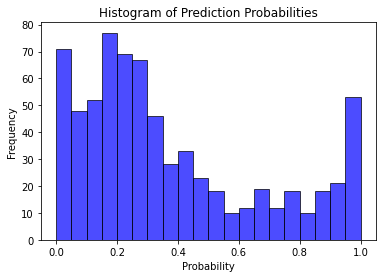

In [211]:
import matplotlib.pyplot as plt

# Assuming 'predictions' contains your model's prediction probabilities
# Flatten the array if it's multi-dimensional
flattened_predictions = predictions.flatten()

# Plot a histogram
plt.hist(flattened_predictions, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Prediction Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()


In [212]:
predictions

array([[1.14861637e-01],
       [2.01177597e-01],
       [1.74077287e-01],
       [1.81549728e-01],
       [9.67939273e-02],
       [4.71103579e-01],
       [3.87074649e-01],
       [1.55861035e-01],
       [5.08747816e-01],
       [1.40554577e-01],
       [1.20802484e-01],
       [1.74956262e-01],
       [2.04700127e-01],
       [5.22559047e-01],
       [2.04747260e-01],
       [2.99941748e-01],
       [1.17047049e-01],
       [1.26392692e-01],
       [2.94269204e-01],
       [1.66709334e-01],
       [3.40438128e-01],
       [1.42035648e-01],
       [4.06654537e-01],
       [8.81662369e-02],
       [3.52796942e-01],
       [2.47967601e-01],
       [1.97249070e-01],
       [3.28020066e-01],
       [1.54239163e-01],
       [2.81208456e-01],
       [1.62286699e-01],
       [2.14026809e-01],
       [2.47969925e-01],
       [1.67590678e-01],
       [8.82273138e-01],
       [5.26104085e-02],
       [4.69458669e-01],
       [1.89304501e-01],
       [1.13308609e-01],
       [3.78516704e-01],


In [213]:
second_window_data

,Ticker,Date,Time,Close,Hourly_Log_Return,Previous Close,Actual Change,Next_Hour_Direction
720,BTC,1/31/2014,0:00:00,838.00,-0.013677,849.54,-1.358382,0
721,BTC,1/31/2014,1:00:00,849.54,0.003632,846.46,0.363868,1
722,BTC,1/31/2014,2:00:00,846.46,-0.000248,846.67,-0.024803,0
723,BTC,1/31/2014,3:00:00,846.67,0.002377,844.66,0.237966,1
724,BTC,1/31/2014,4:00:00,844.66,-0.001408,845.85,-0.140687,0
...,...,...,...,...,...,...,...,...
1435,BTC,3/1/2014,19:00:00,554.04,0.000108,553.98,0.010831,1
1436,BTC,3/1/2014,20:00:00,553.98,0.000686,553.60,0.068642,0
1437,BTC,3/1/2014,21:00:00,553.60,-0.024164,567.14,-2.387418,0
1438,BTC,3/1/2014,22:00:00,567.14,0.004967,564.33,0.497936,1


In [214]:
len(second_window_data)

720

In [215]:
# Offset to align predictions with actual values
offset = window_size + sequence_length

# Add predictions to the dataset (assuming predictions are in 'predicted_directions' variable)
second_window_data['Predicted_Direction'] = np.nan
second_window_data.loc[offset:offset+len(predicted_directions)-1, 'Predicted_Direction'] = predicted_directions.flatten()



<ipython-input-215-6ca747f1f43e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_window_data['Predicted_Direction'] = np.nan


In [216]:
second_window_data = second_window_data.dropna()
len(second_window_data)

705

In [217]:
second_window_data

,Ticker,Date,Time,Close,Hourly_Log_Return,Previous Close,Actual Change,Next_Hour_Direction,Predicted_Direction
735,BTC,1/31/2014,15:00:00,849.24,0.000224,849.05,0.022378,0,0.0
736,BTC,1/31/2014,16:00:00,849.05,0.000884,848.30,0.088412,0,0.0
737,BTC,1/31/2014,17:00:00,848.30,0.000248,848.09,0.024762,0,0.0
738,BTC,1/31/2014,18:00:00,848.09,0.005285,843.62,0.529859,0,0.0
739,BTC,1/31/2014,19:00:00,843.62,-0.001481,844.87,-0.147952,0,0.0
...,...,...,...,...,...,...,...,...,...
1435,BTC,3/1/2014,19:00:00,554.04,0.000108,553.98,0.010831,1,0.0
1436,BTC,3/1/2014,20:00:00,553.98,0.000686,553.60,0.068642,0,0.0
1437,BTC,3/1/2014,21:00:00,553.60,-0.024164,567.14,-2.387418,0,0.0
1438,BTC,3/1/2014,22:00:00,567.14,0.004967,564.33,0.497936,1,1.0


In [218]:
second_window_data['Prediction_Probability'] = predictions
second_window_data

<ipython-input-218-65e3e1774e61>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_window_data['Prediction_Probability'] = predictions


,Ticker,Date,Time,Close,Hourly_Log_Return,Previous Close,Actual Change,Next_Hour_Direction,Predicted_Direction,Prediction_Probability
735,BTC,1/31/2014,15:00:00,849.24,0.000224,849.05,0.022378,0,0.0,0.114862
736,BTC,1/31/2014,16:00:00,849.05,0.000884,848.30,0.088412,0,0.0,0.201178
737,BTC,1/31/2014,17:00:00,848.30,0.000248,848.09,0.024762,0,0.0,0.174077
738,BTC,1/31/2014,18:00:00,848.09,0.005285,843.62,0.529859,0,0.0,0.181550
739,BTC,1/31/2014,19:00:00,843.62,-0.001481,844.87,-0.147952,0,0.0,0.096794
...,...,...,...,...,...,...,...,...,...,...
1435,BTC,3/1/2014,19:00:00,554.04,0.000108,553.98,0.010831,1,0.0,0.435693
1436,BTC,3/1/2014,20:00:00,553.98,0.000686,553.60,0.068642,0,0.0,0.268154
1437,BTC,3/1/2014,21:00:00,553.60,-0.024164,567.14,-2.387418,0,0.0,0.148936
1438,BTC,3/1/2014,22:00:00,567.14,0.004967,564.33,0.497936,1,1.0,0.990133


Accuracy: 0.8553191489361702


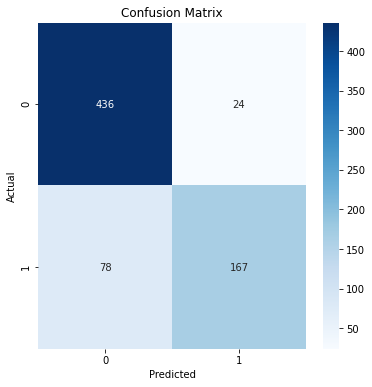

In [219]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate accuracy
accuracy = accuracy_score(second_window_data['Next_Hour_Direction'], second_window_data['Predicted_Direction'])
print(f'Accuracy: {accuracy}')

# Create a confusion matrix
cm = confusion_matrix(second_window_data['Next_Hour_Direction'], second_window_data['Predicted_Direction'])

# Plot the confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


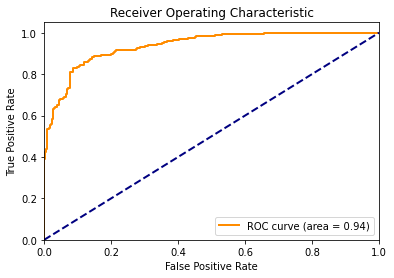

In [220]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(second_window_data['Next_Hour_Direction'], second_window_data['Prediction_Probability'].dropna())
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [221]:
# Assuming 'Next_Hour_Direction' is the column you want to modify
second_window_data['Next_Hour_Direction'] = second_window_data['Next_Hour_Direction'].apply(lambda x: 'Up' if x == 1 else 'Down')
second_window_data['Predicted_Direction'] = second_window_data['Predicted_Direction'].apply(lambda x: 'Up' if x == 1 else 'Down')

second_window_data

<ipython-input-221-c70c245973b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_window_data['Next_Hour_Direction'] = second_window_data['Next_Hour_Direction'].apply(lambda x: 'Up' if x == 1 else 'Down')
<ipython-input-221-c70c245973b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_window_data['Predicted_Direction'] = second_window_data['Predicted_Direction'].apply(lambda x: 'Up' if x == 1 else 'Down')


,Ticker,Date,Time,Close,Hourly_Log_Return,Previous Close,Actual Change,Next_Hour_Direction,Predicted_Direction,Prediction_Probability
735,BTC,1/31/2014,15:00:00,849.24,0.000224,849.05,0.022378,Down,Down,0.114862
736,BTC,1/31/2014,16:00:00,849.05,0.000884,848.30,0.088412,Down,Down,0.201178
737,BTC,1/31/2014,17:00:00,848.30,0.000248,848.09,0.024762,Down,Down,0.174077
738,BTC,1/31/2014,18:00:00,848.09,0.005285,843.62,0.529859,Down,Down,0.181550
739,BTC,1/31/2014,19:00:00,843.62,-0.001481,844.87,-0.147952,Down,Down,0.096794
...,...,...,...,...,...,...,...,...,...,...
1435,BTC,3/1/2014,19:00:00,554.04,0.000108,553.98,0.010831,Up,Down,0.435693
1436,BTC,3/1/2014,20:00:00,553.98,0.000686,553.60,0.068642,Down,Down,0.268154
1437,BTC,3/1/2014,21:00:00,553.60,-0.024164,567.14,-2.387418,Down,Down,0.148936
1438,BTC,3/1/2014,22:00:00,567.14,0.004967,564.33,0.497936,Up,Up,0.990133


In [223]:
len(btc_data)/720


123.96388888888889